This example uses the carvana dataset. Images and masks are resized to 3x64x64.

In [1]:
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # progress bar

sys.path.append('../../src')

## some parameters

In [2]:
batch_size = 32
learning_rate = 1e-3
epochs = 20

## only use dataset and dataloader from pytorch

In [3]:
from albumentations import Compose, Rotate, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision.datasets.utils import download_url, extract_archive, check_integrity

## create dataset
download the zip file (26MB) manually from [here](https://drive.google.com/file/d/1kWxCVAm3CX9jsSZWS2Bx17JK38ASxhk3/view?usp=sharing), put it in a folder called "carvana_data" and unzip it there.

In [4]:
class CarvanaDataset(Dataset):
    def __init__(self, root, train=True, transform=None):

        fn = 'train64' if train else 'test64'
        with open(f'{root}/{fn}', 'rb') as f:
            data = pickle.load(f)
        self.images = (data['images'] / 255).astype(np.float32)
        self.masks = data['masks'].astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index].reshape(64, 64, 3)
        mask = self.masks[index].reshape(64, 64)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"][None, ...]
        return image, mask

In [5]:
transform_augmented = Compose([
    Rotate(limit=35, p=1.0),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.1),
    ToTensorV2()])

transform = Compose([
    ToTensorV2()])

valset, trainset = random_split(CarvanaDataset('./carvana_data', train=True, transform=transform_augmented), [646, 3658])
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = CarvanaDataset('./carvana_data', train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True) # shuffle to show different types of cars

print('size of train set', len(trainset))
print('size of validation set', len(valset))
print('size of test set', len(testset))

files already downloaded
files already downloaded
size of train set 3658
size of validation set 646
size of test set 784


## the rest is done in pytortto
tensors loaded using `pytorch` will be converted to `tortto` tensors.

In [6]:
import tortto as tt
import tortto.nn as nn
import tortto.nn.functional as F
import tortto.optim as optim

## define the model: U-Net

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features):
        super(UNet, self).__init__()
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)
        for f in features:
            self.down.append(DoubleConv(in_channels, f))
            in_channels = f
        self.bottle_neck = DoubleConv(f, 2 * f)
        for f in reversed(features):
            self.up.append(nn.ConvTranspose2d(2 * f, f, kernel_size=2, stride=2))
            self.up.append(DoubleConv(2 * f, f))
        self.out = nn.Conv2d(f, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for m in self.down:
            x = m(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottle_neck(x)
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.up), 2):
            skip_connection = skip_connections[i // 2]
            x = self.up[i](x, output_size=skip_connection.shape[-2:])  # upsample
            x = tt.cat([skip_connections[i // 2], x], dim=1)  # cat
            x = self.up[i + 1](x)  # double conv
        x = self.out(x)
        return x

In [8]:
net = UNet(in_channels=3, out_channels=1, features=[32,64,128,256]).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## train the network

In [9]:
%%time
history = {'train': [], 'val': []}
lowest_loss = 100

for epoch in range(epochs):  # loop over the dataset multiple times
    print(f'epoch {epoch + 1}/{epochs}')
    time.sleep(0.5)
    
    ######################################### train
    net.train()
    loop = tqdm(trainloader)
    train_loss = 0
    for i, (inputs, labels) in enumerate(loop, 1):
        # pass inputs and labels data to tortto tensor
        inpt = tt.tensor(inputs.numpy()).cuda()
        lab = tt.tensor(labels.numpy()).cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inpt)

        # calc loss
        loss = criterion(outputs, lab)
        train_loss += loss.item()

        # backpropagation
        loss.backward()

        # update parameters
        optimizer.step()

    # keep track of train loss every loop
    history['train'].append(train_loss / i)

    ######################################### validation
    net.eval()
    val_loss = 0
    loop = tqdm(valloader)
    with tt.no_grad():
        for i, (inputs, labels) in enumerate(loop, 1):
            # pass inputs and labels to tortto tensor
            inpt = tt.tensor(inputs.numpy()).cuda()
            lab = tt.tensor(labels.numpy()).cuda()

            # forward
            outputs = net(inpt)

            # calculate loss
            loss = criterion(outputs, lab)
            val_loss += loss.item()

        # keep track of validation loss every loop
        history['val'].append(val_loss / i)
        print(' - val_loss: {:.4f}\n'.format(history['val'][-1]))
    
    ######################################### save checkpoint and loss history
    if epoch > 10 and history['val'][-1] < lowest_loss:
        checkpoint = {
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        tt.save(checkpoint, f'unet_checkpoint_{str(epoch + 1).zfill(3)}.npy')
        tt.save(history, 'loss_history.npy')
        lowest_loss = history['val'][-1]

epoch 1/20


100%|██████████| 21/21 [00:01<00:00, 20.90it/s]


 - val_loss: 0.0969

epoch 2/20


100%|██████████| 21/21 [00:01<00:00, 20.55it/s]


 - val_loss: 0.0553

epoch 3/20


100%|██████████| 21/21 [00:01<00:00, 20.81it/s]


 - val_loss: 0.0489

epoch 4/20


100%|██████████| 21/21 [00:01<00:00, 20.95it/s]


 - val_loss: 0.0404

epoch 5/20


100%|██████████| 21/21 [00:01<00:00, 20.94it/s]


 - val_loss: 0.0399

epoch 6/20


100%|██████████| 21/21 [00:01<00:00, 20.90it/s]


 - val_loss: 0.0388

epoch 7/20


100%|██████████| 21/21 [00:01<00:00, 20.96it/s]


 - val_loss: 0.0347

epoch 8/20


100%|██████████| 21/21 [00:01<00:00, 20.93it/s]


 - val_loss: 0.0330

epoch 9/20


100%|██████████| 21/21 [00:01<00:00, 20.93it/s]


 - val_loss: 0.0326

epoch 10/20


100%|██████████| 21/21 [00:01<00:00, 20.99it/s]


 - val_loss: 0.0304

epoch 11/20


100%|██████████| 21/21 [00:01<00:00, 20.90it/s]


 - val_loss: 0.0313

epoch 12/20


100%|██████████| 21/21 [00:01<00:00, 20.95it/s]


 - val_loss: 0.0319

epoch 13/20


100%|██████████| 21/21 [00:01<00:00, 20.96it/s]


 - val_loss: 0.0294

epoch 14/20


100%|██████████| 21/21 [00:01<00:00, 20.78it/s]


 - val_loss: 0.0293

epoch 15/20


100%|██████████| 21/21 [00:01<00:00, 20.90it/s]


 - val_loss: 0.0345

epoch 16/20


100%|██████████| 21/21 [00:01<00:00, 20.83it/s]


 - val_loss: 0.0289

epoch 17/20


100%|██████████| 21/21 [00:01<00:00, 20.91it/s]


 - val_loss: 0.0284

epoch 18/20


100%|██████████| 21/21 [00:01<00:00, 20.97it/s]


 - val_loss: 0.0399

epoch 19/20


100%|██████████| 21/21 [00:01<00:00, 20.88it/s]


 - val_loss: 0.0308

epoch 20/20


100%|██████████| 21/21 [00:01<00:00, 20.79it/s]


 - val_loss: 0.0275

CPU times: user 5min 50s, sys: 1min 2s, total: 6min 52s
Wall time: 7min 2s


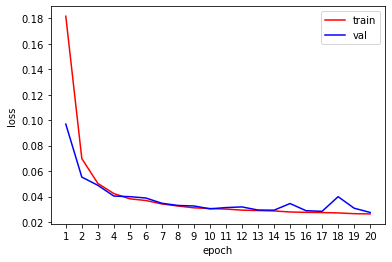

In [10]:
plt.plot(history['train'], 'r', label='train')
plt.plot(history['val'], 'b', label='val')
plt.xticks(ticks=range(len(history['train'])), labels=range(1, 1 + len(history['train'])))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## evaluation on test set

load the last checkpoint, because its validation loss is the lowest.

In [11]:
# load checkpoint
checkpoint = tt.load('unet_checkpoint_020.npy')

In [12]:
%%time
net.eval()
test_loss = 0
with tt.no_grad():
    loop = tqdm(testloader)
    for i, (inputs, labels) in enumerate(loop, 1):
        # pass inputs and labels to tortto tensor
        inpt = tt.tensor(inputs.numpy()).cuda()
        lab = tt.tensor(labels.numpy()).cuda()

        # calculate outputs by running images through the network 
        outputs = net(inpt)

        # calculate loss
        loss = criterion(outputs, lab)
        test_loss += loss.item()

time.sleep(0.5)
print(' - test_loss: {:.4f}\n'.format(test_loss / i))

100%|██████████| 25/25 [00:01<00:00, 22.26it/s]


 - test_loss: 0.0222

CPU times: user 970 ms, sys: 164 ms, total: 1.13 s
Wall time: 1.63 s


## some examples

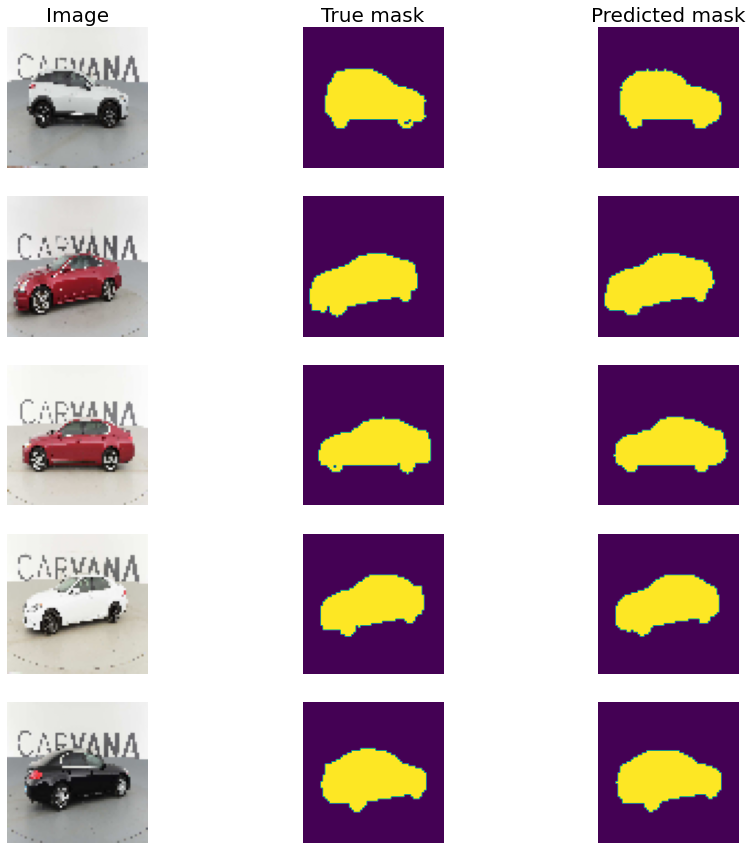

In [13]:
fig, axs = plt.subplots(5, 3, figsize=(15, 15))
for n, ax in enumerate(axs.flat):
    if n % 3 == 0:
        ax.imshow(np.moveaxis(inpt.data[n // 3], -3, -1).get())
        ax.axis('off')
        if n == 0:
            ax.set_title('Image', fontsize=20)
    if n % 3 == 1:
        ax.imshow(lab.data[n // 3][0].get())
        ax.axis('off')
        if n == 1:
            ax.set_title('True mask', fontsize=20)
    if n % 3 == 2:
        ax.imshow(tt.sigmoid(outputs[n // 3][0]).data.get() > 0.5)
        ax.axis('off')
        if n == 2:
            ax.set_title('Predicted mask', fontsize=20)